In [1]:
library(scAnnoX)
library(SingleCellExperiment)

Loading required package: Seurat

Attaching SeuratObject

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

Loading required package: dplyr

Warning message:
"package 'dplyr' was built under R version 4.3.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: HGNChelper

Loading required package: devtools

Loading required package: usethis

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.3.2"

Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked fr

In [2]:
test.obj <- system.file('data', 'test.obj.rds', package = 'scAnnoX') %>% readRDS(.)
ref.obj <- system.file('data', 'ref.obj.rds', package = 'scAnnoX') %>% readRDS(.)

### Exclusively employed a singular single-cell annotation tool.

#### A representative instance involves the utilization of an annotation tool grounded in a reference dataset, while another illustration entails the use of an annotation tool predicated upon a marker gene.

In [3]:
# Take one of the refernce-based annotation tools for example.
pred.obj <- autoAnnoTools(
    test.obj,
    ref.obj = ref.obj,
    ref.ctype = 'CellType',
    marker.lst = marker.lst,
    method = 'SingleR',
    select.marker = 'Seurat',
    top.k = 30,
    strategy = 'refernce-based'
) 
head(pred.obj)

,orig.ident,nCount_RNA,nFeature_RNA,cell_id,experiment,assignment_LB,CellType,RNA_snn_res.0.8,seurat_clusters,SingleR
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>
A1_he2,A1,10704.083,2217,A1_he2,he2,HE,HE,1,1,HE
A1_huvec,A1,10841.500,2153,A1_huvec,huvec,EC,EC,3,3,EC
A10_he1,A10,9359.439,1823,A10_he1,he1,HE,HE,1,1,HE
A10_lb2,A10,7126.247,1220,A10_lb2,lb2,EC-LB,EC-LB,5,5,EC-LB
A10_lb5,A10,7614.329,1522,A10_lb5,lb5,MC-LB,MC-LB,2,2,MC-LB
A11_he1,A11,5043.217,1031,A11_he1,he1,HE,HE,1,1,HE-LB
A11_lb5,A11,7944.145,1395,A11_lb5,lb5,EC-LB,EC-LB,5,5,EC-LB
A12_he1,A12,8498.051,1690,A12_he1,he1,HE,HE,1,1,HE
A12_huvec,A12,11571.679,2287,A12_huvec,huvec,EC,EC,3,3,EC


In [4]:
# Take one of the marker-based annotation tools for example.
Idents(ref.obj) <- ref.obj$CellType
marker.lst <- findMarkerToolsForSc(ref.obj, to.list = TRUE, top.k = 30)
pred.obj <- autoAnnoTools(
    test.obj,
    ref.obj = ref.obj,
    ref.ctype = 'CellType',
    marker.lst = marker.lst,
    method = 'SCINA',
    select.marker = 'Seurat',
    top.k = 30,
    strategy = 'marker-based'
) 
head(pred.obj)

Calculating cluster MC-LB

Calculating cluster MC

Calculating cluster HE

Calculating cluster EC

Calculating cluster EC-LB

Calculating cluster HE-LB



,orig.ident,nCount_RNA,nFeature_RNA,cell_id,experiment,assignment_LB,CellType,RNA_snn_res.0.8,seurat_clusters,SCINA
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>
A1_he2,A1,10704.083,2217,A1_he2,he2,HE,HE,1,1,HE
A1_huvec,A1,10841.500,2153,A1_huvec,huvec,EC,EC,3,3,EC
A10_he1,A10,9359.439,1823,A10_he1,he1,HE,HE,1,1,HE
A10_lb2,A10,7126.247,1220,A10_lb2,lb2,EC-LB,EC-LB,5,5,EC-LB
A10_lb5,A10,7614.329,1522,A10_lb5,lb5,MC-LB,MC-LB,2,2,MC-LB
A11_he1,A11,5043.217,1031,A11_he1,he1,HE,HE,1,1,HE
A11_lb5,A11,7944.145,1395,A11_lb5,lb5,EC-LB,EC-LB,5,5,EC-LB
A12_he1,A12,8498.051,1690,A12_he1,he1,HE,HE,1,1,HE
A12_huvec,A12,11571.679,2287,A12_huvec,huvec,EC,EC,3,3,EC


### Employed a multitude of single-cell annotation tools.
#### Assembling a vector of diverse annotation tools and iteratively annotating the tools within the vector, we generate annotation results encompassing a variety of tools.

In [5]:
Idents(ref.obj) <- ref.obj$CellType
marker.lst <- findMarkerToolsForSc(ref.obj, to.list = TRUE, top.k = 30)

Calculating cluster MC-LB

Calculating cluster MC

Calculating cluster HE

Calculating cluster EC

Calculating cluster EC-LB

Calculating cluster HE-LB



In [6]:
anno.tools <- c('SingleR', 'Seurat', 'sciBet', 'scmap', 'CHETAH', 'scSorter', 'sc.type', 'cellID', 'scCATCH', 'SCINA')
marker.based <- c('scSorter', 'sc.type', 'cellID', 'scCATCH', 'SCINA')

In [7]:
anno.res <- lapply(anno.tools, function(tool) {
    print(sprintf('Running %s...\n', tool))
    bool.val <- ifelse(tool %in% marker.based, 'marker-based', 'refernce-based')
    
    tmp.obj <- autoAnnoTools(
        test.obj,
        ref.obj = ref.obj,
        ref.ctype = 'CellType',
        marker.lst = marker.lst,
        method = tool,
        select.marker = 'Seurat',
        top.k = 30,
        strategy = bool.val
    ) 
    tmp.obj@meta.data[, ncol(tmp.obj@meta.data)]
}) %>% do.call(cbind, .) %>% `colnames<-`(anno.tools)

[1] "Running SingleR...\n"
[1] "Running Seurat...\n"


Performing PCA on the provided reference using 3787 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 511 anchors

Filtering anchors

	Retained 505 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



[1] "Running sciBet...\n"
[1] "Running scmap...\n"


ℹ Loading scmap


[1] "Hi"


Warning message in linearModel(object, n_features):
"Your object does not contain counts() slot. Dropouts were calculated using logcounts() slot..."
Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



[1] "Hi"


Warning message in linearModel(object, n_features):
"Your object does not contain counts() slot. Dropouts were calculated using logcounts() slot..."
Parameter M was not provided, will use M = n_features / 10 (if n_features <= 1000), where n_features is the number of selected features, and M = 100 otherwise.

Parameter k was not provided, will use k = sqrt(number_of_cells)



[1] "Running CHETAH...\n"


Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Preparing data....    


Running analysis... 




[1] "Running scSorter...\n"


Warning message in data_preprocess(expr, anno_processed):
"The following specified marker genes are not found from the expression data: COL6A2."


[1] "Running sc.type...\n"
[1] "Running cellID...\n"


Warning message:
"replacing previous import 'data.table::shift' by 'tictoc::shift' when loading 'CelliD'"
Computing Fuzzy Matrix



0.07 sec elapsed


Computing SVD



1.67 sec elapsed


Computing Coordinates



0.09 sec elapsed



calculating distance


ranking genes

6 pathways kept for hypergeometric test out of 6, 0 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




[1] "Running scCATCH...\n"


ℹ Loading scCATCH

[+++++++++>--------------------] Finished: 33% Time 00:00:00

[++++++++++++++>---------------] Finished: 50% Time 00:00:01

[+++++++++++++++++++>----------] Finished: 67% Time 00:00:01

[++++++++++++++++++++++++>-----] Finished: 83% Time 00:00:02

[++++++++++++++++++++++++++++++] Finished:100% Time 00:00:02



[++++++++++++++>---------------] Finished: 50% Time 00:00:00

[+++++++++++++++++++>----------] Finished: 67% Time 00:00:00

[++++++++++++++++++++++++>-----] Finished: 83% Time 00:00:00

[++++++++++++++++++++++++++++++] Finished:100% Time 00:00:00




[1] "Running SCINA...\n"


### Obtaining Predictive Results of "scAnnoX"

In [8]:
scAnnoX <- annoResult(anno.res)
head(scAnnoX)

,SingleR,Seurat,sciBet,scmap,CHETAH,scSorter,sc.type,cellID,scCATCH,SCINA,scAnnoX
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,HE,HE,HE,HE,HE,HE,HE,HE,HE,HE,HE
2,EC,EC,EC,EC,EC,EC,EC,EC,EC,EC,EC
3,HE,HE,HE,HE,HE,HE,HE,unassigned,HE,HE,HE
4,EC-LB,EC-LB,EC-LB,EC-LB,EC-LB,EC-LB,EC-LB,EC-LB,EC-LB,EC-LB,EC-LB
5,MC-LB,MC-LB,MC-LB,MC-LB,MC-LB,MC-LB,MC-LB,MC-LB,MC-LB,MC-LB,MC-LB
6,HE-LB,HE,HE-LB,HE,HE-LB,HE,HE,unassigned,HE,HE,HE


### Visualization
####  Show annotation results.

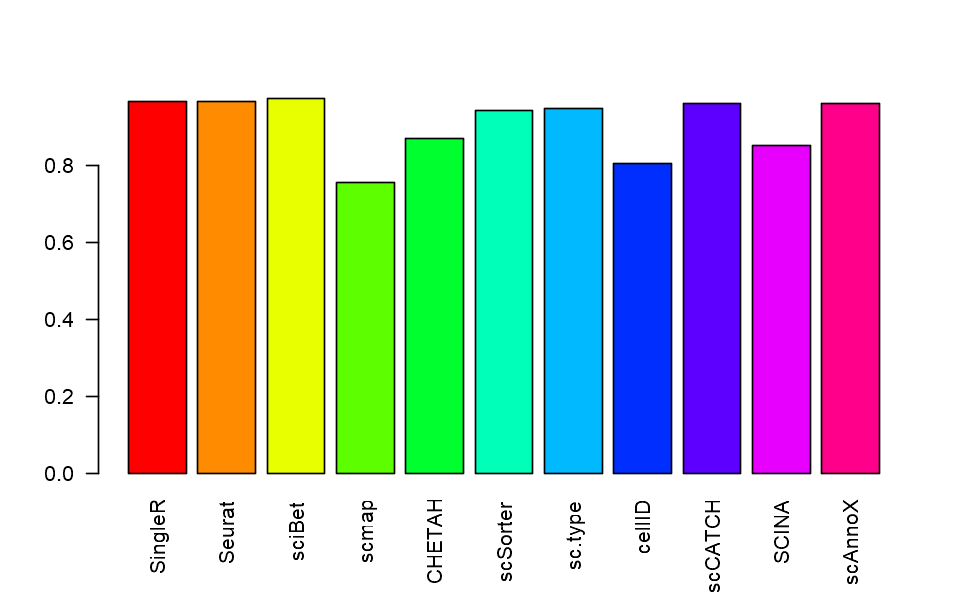

In [9]:
acc <- apply(scAnnoX, 2, function(xx) sum(test.obj$CellType == xx) / ncol(test.obj))
options(repr.plot.width = 8, repr.plot.height = 5)
barplot(acc, las = 2 , col = rainbow(11))